In [149]:
!conda install -y astropy[all]
from astropy.io import fits
import numpy as np
import glob
from astropy import units as u
#Import astropy cutout2d
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

#Use astropy to load in the fits files 'coadd.fits' and 'coadd600.fits'
hdulist = fits.open('coaddh.fits') 
hdulist600 = fits.open('coaddR.fits')

#Show the headers of the fits files
print(hdulist[0].header)









zsh:1: no matches found: astropy[all]
SIMPLE  =                    T / This is a FITS file                            BITPIX  =                  -32 /                                                NAXIS   =                    2 /                                                NAXIS1  =                 2971 / Number of pixels along this axis               NAXIS2  =                 3096 / Number of pixels along this axis               EXTEND  =                    T / This file may contain FITS extensions          EQUINOX =   2.000000000000E+03 / Mean equinox                                   MJD-OBS =   5.966017589700E+04 / Modified Julian date at start                  RADESYS = 'ICRS    '           / Astrometric system                             CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              CUNIT1  = 'deg     '           / Axis unit                                      CRVAL1  =   1.865291666667E+02 / World coordinate on this axis                  CR

In [165]:
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm


def cutout(hdu, position, size, outputname):
    wcs = WCS(hdu[0].header)
    cutout = Cutout2D(hdu[0].data, position ,size, wcs = wcs)

    #Show the image with logarithmic scale
    plt.imshow(cutout.data, origin='lower', cmap='gray', norm=LogNorm(vmin=0.001, vmax=np.max(cutout.data)))
    plt.colorbar()
    plt.show()

    plt.imshow(hdu[0].data, origin='lower', norm=LogNorm(vmin=2, vmax=np.max(cutout.data)))
    cutout.plot_on_original(color='lime', linewidth=1)
    plt.show()
    
    #Save cutout.data to a new fits file
    img_hdu = fits.PrimaryHDU(cutout.data, header=hdu[0].header)
    img_hdu.writeto(outputname + '.fits', overwrite=True) 

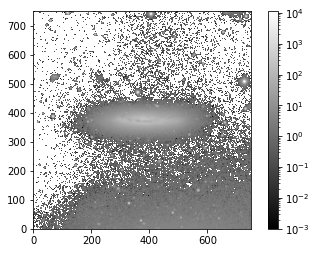

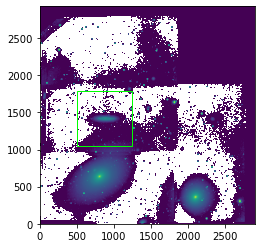

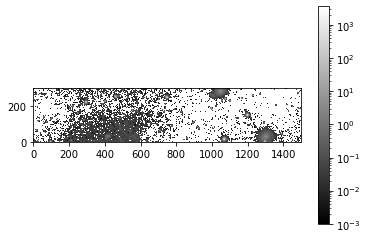

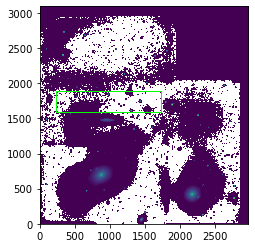

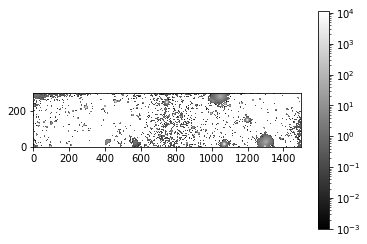

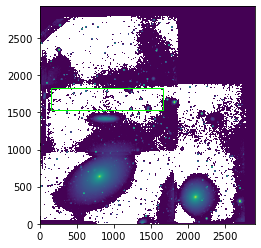

(3096, 2971)
(2928, 2893)


In [186]:
data = hdulist600[0].data
#Position of NGC4402 is 12h26m07.0s, +13d06m45.0s (ICRS)
position = SkyCoord('12h26m08.0s', '+13d06m45.0s', frame='fk5')
size = (750*u.pixel, 750*u.pixel)


cutout(hdulist600, position, size, 'NGC4402_Rwide')
plt.show()

position2 = SkyCoord('12h26m06.3s', '+13d10m10s', frame='fk5')
#position2 = (len(hdulist[0].data)/2+75, len(hdulist[0].data)/2+60)
size2 = (300*u.pixel, 1500*u.pixel)

cutout(hdulist, position2, size2, 'hcutout')

#position3 = SkyCoord('12h26m35.0s', '+13d07m52.7s', frame='fk5')
#position3 = (len(hdulist[0].data)/2, len(hdulist[0].data)/2)

cutout(hdulist600, position2, size2, 'Rcutout')

print(hdulist[0].data.shape)
print(hdulist600[0].data.shape)

25070
25071
237
252.78488
[12.23454995]


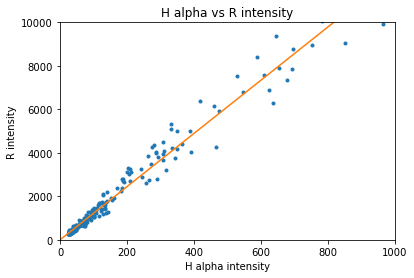

In [190]:
#Now lets work with the sky background to do a continuum subtraction to get the h alpha emission line

#Use astropy to load in the fits files 'coadd.fits' and 'coadd600.fits'
ha = fits.open('hcutout.fits') 
R = fits.open('Rcutout.fits')

hdata = ha[0].data
Rdata = R[0].data
#Find the index where Rdata and hdata are maximal and print that index


#plt.plot(hdata, Rdata)
Rdata.flatten()
hdata.flatten()
print(np.argmax(hdata.flatten()))
print(np.argmax(Rdata.flatten()))

mask = (hdata.flatten() > 25) & (hdata.flatten() < 1000)

assert len(mask) == len(Rdata.flatten()) & len(mask) == len(hdata.flatten()), "The lengths of the arrays are not the same"
#filter out the points of hdata and Rdata where hdata is smaller than 15
hdataflat = hdata.flatten()[mask]
Rdataflat = Rdata.flatten()[mask]

print(len(hdataflat))
print(min(Rdataflat))
#Plot the hdata and Rdata arrays against eachother to see if they are the same
plt.plot(hdataflat, Rdataflat, '.')
#plt.xlim(0,500)


def line(x,a):
    return a*x

#Fit a line to the data and return the slope. intercept = 0
from scipy.optimize import curve_fit
popt, pcov = curve_fit(line, hdataflat, Rdataflat)
print(popt)
plt.plot(range(0, int(max(hdata.flatten()))), line(range(0, int(max(hdata.flatten()))), popt[0]))
plt.xlim(0,1000)
plt.ylim(0,10000)
plt.xlabel('H alpha intensity')
plt.ylabel('R intensity')
plt.title('H alpha vs R intensity')
plt.show()



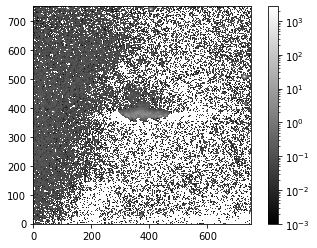

In [189]:
ha4402 = fits.open('NGC4402_hawide.fits') 
R4402 = fits.open('NGC4402_Rwide.fits')
hadata = ha4402[0].data
Rdata = R4402[0].data
continuumsub = hadata - Rdata/popt[0]
#Show the image with logarithmic scale
plt.imshow(continuumsub, origin='lower', cmap='gray', norm=LogNorm(vmin=0.001, vmax=np.max(continuumsub)))
plt.colorbar()
plt.show()

img_hdu = fits.PrimaryHDU(continuumsub, header=hdulist[0].header)
img_hdu.writeto('continuumsub.fits', overwrite=True) 